In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Basic Data and EDA

In [2]:
data=pd.read_csv(r"C:\Users\HOME\Downloads\reviews_data_dump\reviews_badminton\data.csv")
data.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [4]:
data.loc[0,"Review text"]

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.READ MORE'

In [30]:
df=data[['Review text','Ratings']]
df.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [31]:
df.Ratings.value_counts()

5    5080
4    1746
1     769
3     615
2     308
Name: Ratings, dtype: int64

In [32]:
df['Ratings']=[ 'Negative Review' if 1 <= i <= 3  else 'Positive Review'  for i in df['Ratings']]

In [33]:
df["Ratings"].value_counts()

Positive Review    6826
Negative Review    1692
Name: Ratings, dtype: int64

In [34]:
df["Review text"].isnull().sum()

8

In [35]:
df.dropna(axis=0,inplace=True)
df["Review text"].isnull().sum()

0

In [36]:
df.shape

(8510, 2)

## Defining Input and Output features and Splitting the data

In [37]:
x=df["Review text"]
y=df["Ratings"]


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)

print("x_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

x_train: (6808,)
x_test: (1702,)
y_train: (6808,)
y_test: (1702,)


In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(data):
    wc=WordCloud(background_color='black', width=1600,height=1800).generate(''.join(data))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

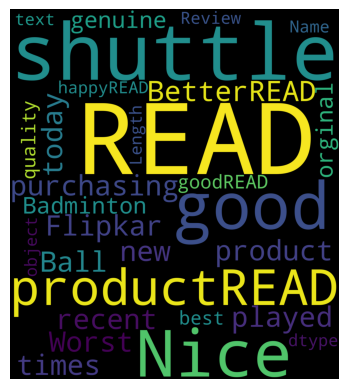

In [39]:
wordcloud(str(x_train))

## Data Preprocessing

In [40]:
import nltk
from textblob import TextBlob,Word
from nltk.corpus import stopwords
sw=stopwords.words("english")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lematizer=WordNetLemmatizer()
import string


def clean(text):
    #checking punctuation and removing numbers
    text="".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    #converting lower case
    text=text.lower()
    #tokenization
    tokens=nltk.word_tokenize(text)
    #lematization
    lematized_tokens=[lematizer.lemmatize(token) for token in tokens]
    #removeing stopwords
    filtered_tokens=[word for word in lematized_tokens if word.lower() not in sw]
    
    #join and return
    return " ".join(filtered_tokens)

## Model Building and Model Evaluation

In [41]:
#data preprocessing the x_train
from sklearn.feature_extraction.text import CountVectorizer
import time
vectorizer=CountVectorizer(preprocessor=clean)

%time x_train_vec=vectorizer.fit_transform(x_train)

print(x_train_vec.shape)

Wall time: 2.5 s
(6808, 3096)


In [42]:
#data preprocessing the x_test

%time x_test_vec=vectorizer.transform(x_test)

print(x_test_vec.shape)

Wall time: 572 ms
(1702, 3096)


In [43]:
#building a model

from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

%time logreg.fit(x_train_vec,y_train)

Wall time: 220 ms


LogisticRegression()

In [46]:
#evaluating the model

from sklearn import metrics

y_train_pred=logreg.predict(x_train_vec)

metrics.accuracy_score(y_train, y_train_pred)

0.913337250293772

In [48]:
cm=metrics.confusion_matrix(y_train,y_train_pred)
cm

array([[ 823,  527],
       [  63, 5395]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

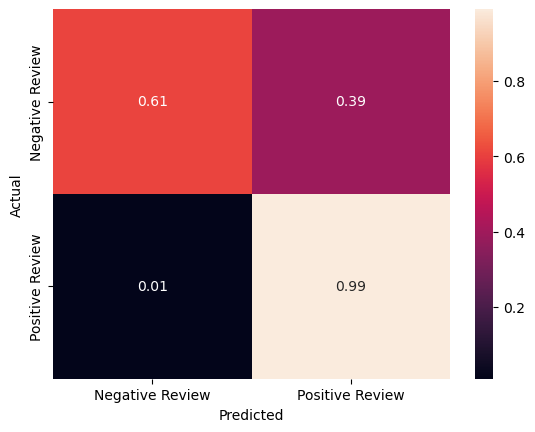

In [49]:
cm=metrics.confusion_matrix(y_train,y_train_pred)
actual=np.sum(cm,axis=1).reshape(-1,1)
cmn=np.round(cm/actual,2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=logreg.classes_,yticklabels=logreg.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [51]:
# evaluating test score
y_test_pred=logreg.predict(x_test_vec)
metrics.accuracy_score(y_test,y_test_pred)

0.8760282021151586

In [52]:
cm=metrics.confusion_matrix(y_test,y_test_pred)
cm

array([[ 160,  177],
       [  34, 1331]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

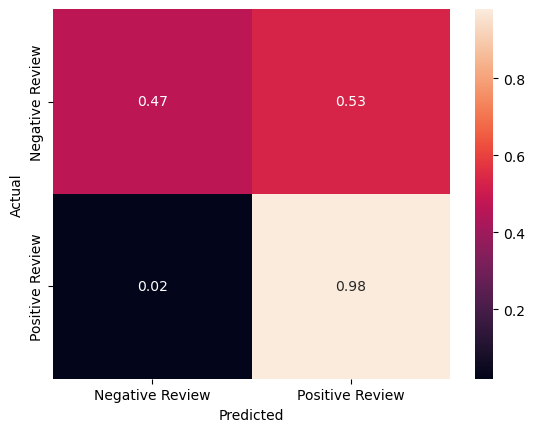

In [54]:
cm=metrics.confusion_matrix(y_test,y_test_pred)
actual=np.sum(cm,axis=1).reshape(-1,1)
cmn=np.round(cm/actual,2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=logreg.classes_,yticklabels=logreg.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [57]:
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred,pos_label=-1,average='micro'))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred,pos_label=-1,average='micro'))

Train Score (F1 Score): 0.9133372502937719
Test Score (F1 Score): 0.8760282021151586


## Creating an Optimal Workflow

In [68]:
%time x_train_clean = x_train.apply(lambda doc: clean(doc))
%time x_test_clean = x_test.apply(lambda doc: clean(doc))

Wall time: 868 ms
Wall time: 250 ms


In [61]:
import joblib
from joblib import Memory

import os

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [73]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
             'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(x_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(x_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 4.8 s
Score on Test Data:  0.8742655699177438
********** decision_tree **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Wall time: 8.28 s
Score on Test Data:  0.8601645123384254
********** logistic_regression **********
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Wall time: 5min 58s
Score on Test Data:  0.8678025851938895


In [74]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.4,
                                    penalty='elasticnet', solver='saga'))])



In [83]:
for name, model in best_models.items():
    print("*" * 10, name, "*" * 10)
    
    joblib.dump(model, f'../ml webapp/best models/{name}.pkl')
    model = joblib.load(f'../ml webapp/best models/{name}.pkl')
    
    start_time = time.time()
    y_train_pred=model.predict(x_train_clean)
    y_test_pred = model.predict(x_test_clean)
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution Time:", execution_time, "seconds")

    print("Train Score (F1):", metrics.f1_score(y_train, y_train_pred, pos_label=-1, average='micro'))
    print("Test Score (F1):", metrics.f1_score(y_test, y_test_pred, pos_label=-1, average='micro'))
    
    model_size = os.path.getsize(f'../ml webapp/best models/{name}.pkl')
    print("Model Size:", model_size, "Bytes")

********** naive_bayes **********
Execution Time: 0.047595977783203125 seconds
Train Score (F1): 0.9036427732079906
Test Score (F1): 0.8742655699177438
Model Size: 180931 Bytes
********** decision_tree **********
Execution Time: 0.06320023536682129 seconds
Train Score (F1): 0.8720622796709753
Test Score (F1): 0.8601645123384254
Model Size: 91747 Bytes
********** logistic_regression **********
Execution Time: 0.05272936820983887 seconds
Train Score (F1): 0.9224441833137487
Test Score (F1): 0.8678025851938895
Model Size: 106835 Bytes
